## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Use GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load & Ready Data (MNIST)

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # تبدیل تصویر خاکستری به 3 کاناله
    transforms.Resize((224, 224)),  # تغییر اندازه برای سازگاری با ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Load & Ready Base Pre-Trained Model (ResNet-50)

In [ ]:
model = models.resnet50(pretrained=True)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

## Reconstract New Model

In [ ]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
model = model.to(device)

## Training function

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

## Evaluate Function

In [ ]:
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

## Main

### Train Model

In [ ]:
print("Training started...")
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

### Evaluate Model

In [ ]:
train_labels, train_preds = evaluate_model(model, train_loader)
test_labels, test_preds = evaluate_model(model, test_loader)

In [ ]:
train_accuracy = accuracy_score(train_labels, train_preds)
train_f1 = f1_score(train_labels, train_preds, average='weighted')
test_accuracy = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds, average='weighted')

In [ ]:
train_cm = confusion_matrix(train_labels, train_preds)
test_cm = confusion_matrix(test_labels, test_preds)

### Result

In [1]:
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
print(f"\nTrain Accuracy: {train_accuracy:.4f}")
print(f"Train F1-Score: {train_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Train Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 205kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.94MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.6MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:

Training started...
Epoch [1/10], Loss: 0.6289
Epoch [2/10], Loss: 0.4728
Epoch [3/10], Loss: 0.4370
Epoch [4/10], Loss: 0.4149
Epoch [5/10], Loss: 0.4013
Epoch [6/10], Loss: 0.3905
Epoch [7/10], Loss: 0.3811
Epoch [8/10], Loss: 0.3732
Epoch [9/10], Loss: 0.3640
Epoch [10/10], Loss: 0.3562

Train Accuracy: 0.8894
Train F1-Score: 0.8891
Test Accuracy: 0.8699
Test F1-Score: 0.8699


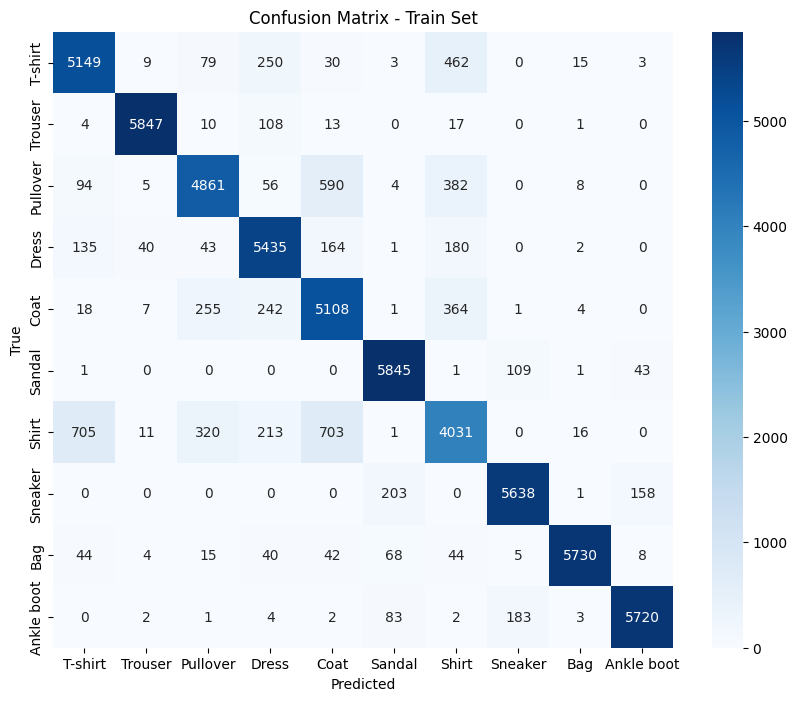

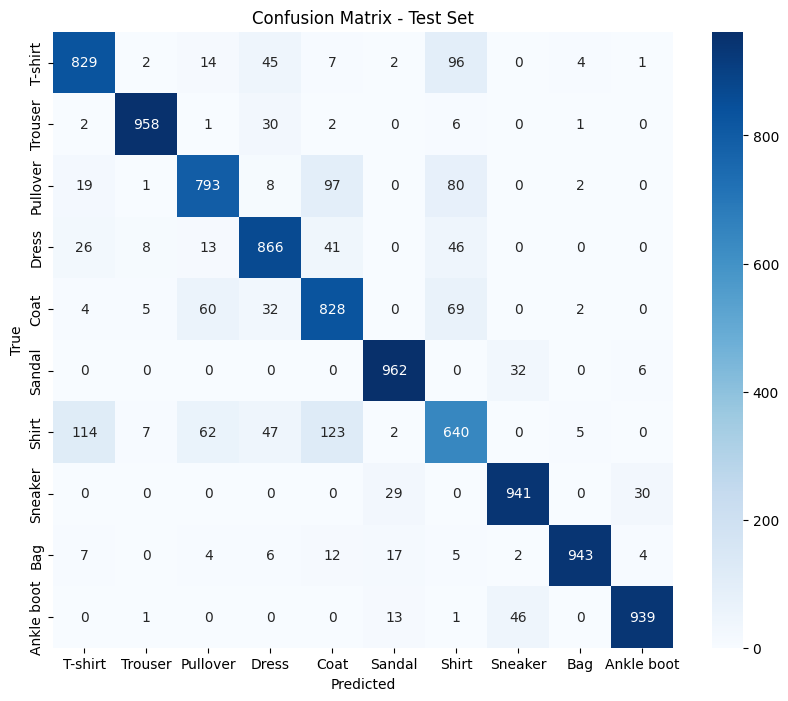

In [1]:
plt.figure(figsize=(10, 8))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()